# Time Series Forecasting

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

C:\Users\User\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Read files

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


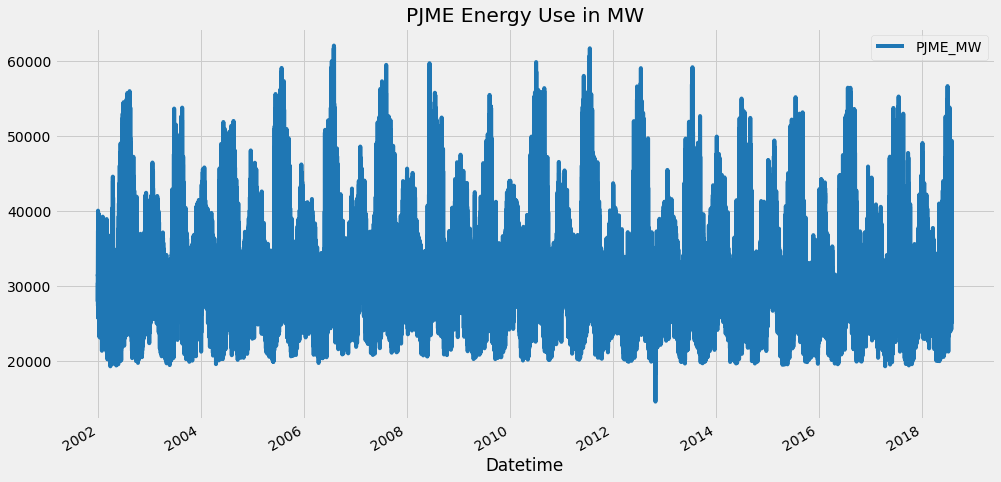

In [4]:
df.plot(figsize = (15,8),
       color = color_pal[0],
       title = 'PJME Energy Use in MW')
plt.show()

## Train/Test split

In [7]:
train = df.iloc[df.index<'01-01-2015']
test = df.iloc[df.index>='01-01-2015']

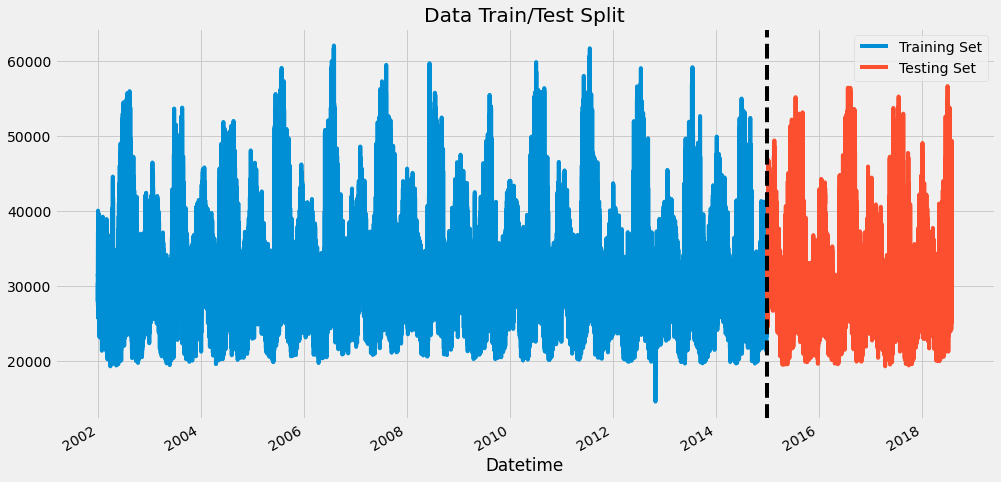

In [8]:
fig, ax = plt.subplots(figsize = (15,8))
train.plot(ax = ax , label= 'training set', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'testing set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

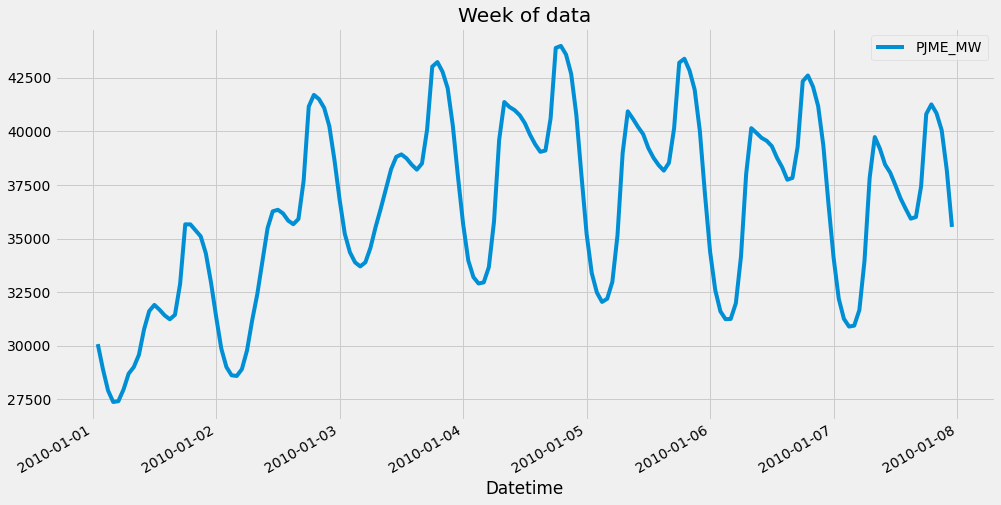

In [9]:
#view one week

df.loc[(df.index> '01-01-2010') & (df.index< '01-08-2010')  ].plot(figsize = (15,8),
       title = 'Week of data')

plt.show()

## Feature creation

In [14]:
# create function to add new columns
def create_feature(df):
    df = df.copy()
    df['hour']= df.index.hour
    df['year'] = df.index.year
    df['quater'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofweek'] = df.index.day_of_week
    return df

df = create_feature(df)

In [15]:
df.head()

,PJME_MW,hour,year,quater,month,dayofweek
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,2002,4,12,1
2002-12-31 02:00:00,25147.0,2,2002,4,12,1
2002-12-31 03:00:00,24574.0,3,2002,4,12,1
2002-12-31 04:00:00,24393.0,4,2002,4,12,1
2002-12-31 05:00:00,24860.0,5,2002,4,12,1


## Visualize target with features

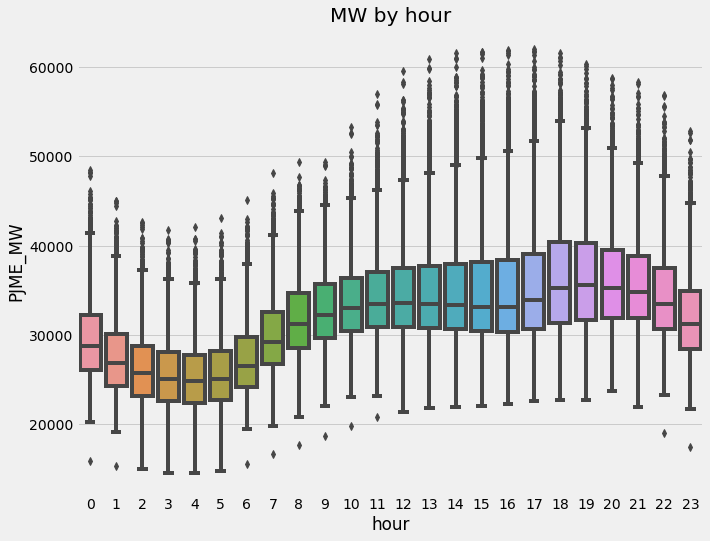

In [21]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(x = df['hour'], y = df['PJME_MW'], ax = ax)
plt.title('MW by hour')
plt.show()

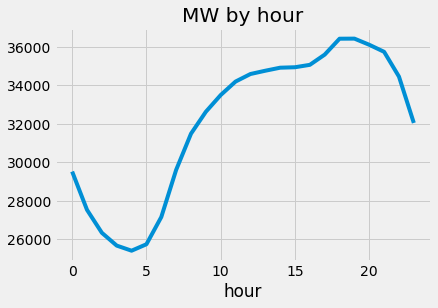

In [40]:
df.groupby('hour')['PJME_MW'].mean().plot()
plt.title('MW by hour')
plt.show()

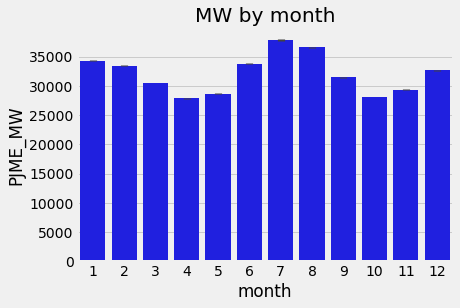

In [30]:
#fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = df['month'], y = df['PJME_MW'], color ='blue')
plt.title('MW by month')
plt.show()

## Create model

In [41]:
df.columns

Index(['PJME_MW', 'hour', 'year', 'quater', 'month', 'dayofweek'], dtype='object')

In [43]:
FEATURES = ['hour', 'year', 'quater', 'month', 'dayofweek']
TARGET = ['PJME_MW']

In [44]:
train = create_feature(train)
test = create_feature(test)

In [45]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [49]:
model = xgb.XGBRegressor(base_score = 0.5,
                        booster = 'gbtree',
                        objective = 'reg:squarederror',
                        max_depth = 3, 
                        learning_rate = 0.01)

model.fit(X_train, y_train, 
         eval_set= [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:32605.25195	validation_1-rmse:31657.31055
[99]	validation_0-rmse:12715.22461	validation_1-rmse:11877.72070


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Feature importance

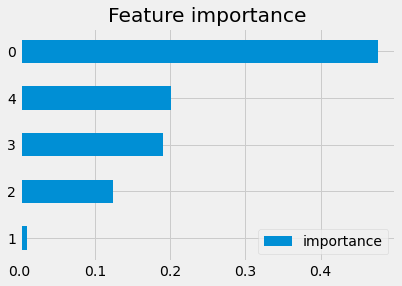

In [76]:
fi = pd.DataFrame(data= model.feature_importances_,
            #index = X_train.columns,
            columns = ['importance'])

fi.sort_values(by = 'importance').plot(kind = 'barh', 
                                      title = 'Feature importance')
plt.show()

In [77]:
for col,score in zip(X_train.columns,model.feature_importances_):
    print(col,score)

hour 0.47546116
year 0.010171293
quater 0.1237862
month 0.19009453
dayofweek 0.20048678


### Forecast on test

In [78]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how = 'left',
             left_index = True, 
             right_index = True)

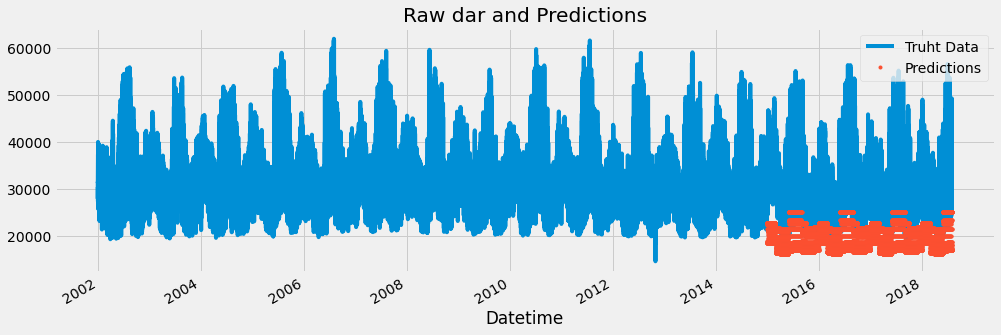

In [87]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot( ax = ax, style = '.')
plt.legend(['Truht Data', 'Predictions'])
plt.title('Raw dar and Predictions')
plt.show()

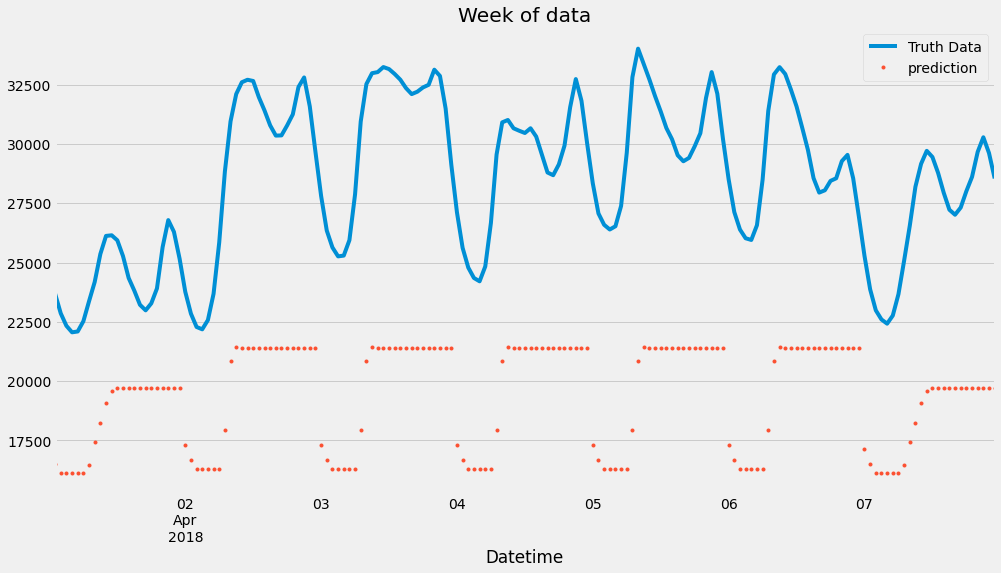

In [88]:
df.loc[(df.index> '04-01-2018') & (df.index< '04-08-2018')  ]['PJME_MW'].plot(figsize = (15,8),
       title = 'Week of data')


df.loc[(df.index> '04-01-2018') & (df.index< '04-08-2018')  ]['prediction'].plot(figsize = (15,8),
       style = '.')

plt.legend(['Truth Data', "prediction"])
plt.show()

In [93]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])).round(2)

31803.72

## Calculate Error

In [101]:
test['error'] = np.abs(test['PJME_MW']- test['prediction'])
test['date'] = test.index.date

In [103]:
test.groupby('date')['error'].mean().nlargest(10)

date
2016-08-12    45511.712364
2015-07-20    45235.069103
2018-07-03    45046.025948
2016-08-11    45013.683638
2018-07-02    45006.654809
2016-08-13    44974.155254
2017-07-20    44559.863558
2015-02-20    44482.706776
2016-07-25    44230.867255
2016-08-14    44217.234130
Name: error, dtype: float64

In [104]:
test.groupby('date')['error'].mean().nsmallest(10)

date
2016-04-24    22586.693254
2016-05-08    22722.744795
2015-04-19    22931.847902
2017-10-01    22986.578405
2016-05-15    23000.493639
2017-05-21    23037.230605
2017-04-23    23056.311083
2017-05-14    23132.418308
2016-04-17    23209.982417
2017-04-15    23325.639245
Name: error, dtype: float64